In [58]:
from cobaya.theory import Theory
from cobaya.tools import load_module
from cobaya.log import LoggedError, get_logger
from cobaya.model import get_model
from cobaya.output import get_output
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt
import numpy as np
import h5py
import pandas as pd
from scipy.stats import gaussian_kde as kde
from scipy.stats import norm, multivariate_normal
from scipy import interpolate
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import os, time, csv
from importlib import reload
#import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [4]:
yr = (u.yr.to(u.s))

In [3]:
NG_freqs_30 = np.array(open('../../../../NANOGrav_12p5/frequencies.txt', 'r').read().splitlines(), dtype=float)
T_NG = 1/NG_freqs_30[0]
NG_freqs_5 = NG_freqs_30[:5]
NG_freqs_5, T_NG, T_NG/31557600

(array([2.45937431e-09, 4.91874862e-09, 7.37812293e-09, 9.83749724e-09,
        1.22968715e-08]),
 406607483.9980211,
 12.884613658770665)

In [4]:
NG_par_names = open('../../../../NANOGrav_12p5/12p5yr_DE438_model2a_PSDspectrum_pars.txt', 'r').read().splitlines()
len(NG_par_names)

120

In [5]:
NG12 = pd.read_csv('../../../../NANOGrav_12p5/12p5yr_DE438_model2a_PSDspectrum_chain', sep=" ", 
                 header=None, 
                 names=NG_par_names+['log_posterior', 'log_likelihood', 'mc_acceptance', 'pt_acceptance'],
                 #usecols=np.arange(90,120),
                 skiprows=30000,
                )
NG12

,B1855+09_red_noise_gamma,B1855+09_red_noise_log10_A,B1937+21_red_noise_gamma,B1937+21_red_noise_log10_A,B1953+29_red_noise_gamma,B1953+29_red_noise_log10_A,J0023+0923_red_noise_gamma,J0023+0923_red_noise_log10_A,J0030+0451_red_noise_gamma,J0030+0451_red_noise_log10_A,...,gw_log10_rho_24,gw_log10_rho_25,gw_log10_rho_26,gw_log10_rho_27,gw_log10_rho_28,gw_log10_rho_29,log_posterior,log_likelihood,mc_acceptance,pt_acceptance
0,3.725684,-13.903462,4.031573,-13.640757,5.240528,-13.487477,1.976037,-13.285288,3.600833,-14.305824,...,-8.252858,-8.202271,-7.902354,-8.331227,-8.267701,-8.712800,4.891798e+06,4.892033e+06,0.522302,1.0
1,3.725684,-13.903462,4.031573,-13.640757,5.240528,-13.487477,1.976037,-13.285288,3.600833,-14.305824,...,-8.252858,-8.202271,-7.902354,-8.331227,-8.267701,-8.712800,4.891798e+06,4.892033e+06,0.522302,1.0
2,3.725684,-13.903462,4.031573,-13.640757,5.394084,-13.513969,1.976037,-13.285288,3.600833,-14.305824,...,-8.252858,-8.202271,-7.902354,-8.331227,-8.267701,-8.712800,4.891798e+06,4.892033e+06,0.522302,1.0
3,3.725684,-13.903462,4.031573,-13.640757,5.394084,-13.513969,1.515473,-13.650164,3.600833,-14.305824,...,-8.252858,-8.202271,-7.902354,-8.331227,-8.267701,-8.712800,4.891798e+06,4.892032e+06,0.522302,1.0
4,3.725684,-13.903462,4.031573,-13.640757,5.394084,-13.513969,1.515473,-13.650164,3.600833,-14.305824,...,-8.252858,-8.202271,-7.902354,-8.331227,-8.267701,-8.712800,4.891798e+06,4.892032e+06,0.522302,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046195,4.734030,-14.084579,3.797494,-13.479965,3.128685,-12.881013,0.365268,-13.081798,4.732403,-18.732835,...,-7.755603,-8.742165,-8.958870,-8.760956,-8.064336,-8.473843,4.891785e+06,4.892020e+06,0.537711,1.0
1046196,4.734030,-14.084579,3.797494,-13.479965,3.128685,-12.881013,0.365268,-13.081798,4.639061,-18.849706,...,-7.755603,-8.742165,-8.958870,-8.760956,-8.064336,-8.473843,4.891785e+06,4.892020e+06,0.537711,1.0
1046197,4.735459,-14.098403,3.766384,-13.472132,3.125946,-12.894378,0.378615,-13.070960,4.637080,-18.853789,...,-7.744935,-8.742618,-8.945494,-8.748695,-8.069009,-8.469007,4.891786e+06,4.892020e+06,0.537711,1.0
1046198,4.735459,-14.098403,3.766384,-13.472132,3.125946,-12.894378,0.378615,-13.070960,4.637080,-18.853789,...,-7.744935,-8.742618,-8.945494,-8.748695,-8.069009,-8.469007,4.891786e+06,4.892021e+06,0.537711,1.0


In [8]:
NG12 = pd.read_csv('../../../../NANOGrav_12p5/12p5yr_DE438_model2a_PSDspectrum_chain', sep=" ", 
                 header=None, 
                 names=NG_par_names+['log_posterior', 'log_likelihood', 'mc_acceptance', 'pt_acceptance'],
                 usecols=np.arange(90,120),
                 skiprows=30000,
                )

NG12 = NG12[::5]  # shrink the sample

In [9]:
NG_low = NG12.iloc[:,:5]
hc_NG_low = NG_low + (np.log10(T_NG*12*np.pi**2) + 3*np.log10(NG_freqs_5))/2
hc_NG_low

,gw_log10_rho_0,gw_log10_rho_1,gw_log10_rho_2,gw_log10_rho_3,gw_log10_rho_4
0,-13.717607,-14.325943,-15.026507,-14.155076,-15.265446
5,-13.717607,-14.325943,-15.026507,-14.155076,-15.265446
10,-13.718186,-14.322858,-15.020632,-14.154660,-15.263280
15,-13.725834,-14.328928,-15.018320,-14.155100,-15.263513
20,-13.725834,-14.328928,-15.018320,-14.155100,-15.263513
...,...,...,...,...,...
1046175,-13.880095,-14.182505,-15.547357,-14.831607,-14.005218
1046180,-13.885312,-14.187445,-15.541916,-14.807142,-14.059514
1046185,-13.885312,-14.187445,-15.541916,-14.807142,-14.059514
1046190,-13.885312,-14.187445,-15.541916,-14.807142,-14.059514


(1.9952623149688828e-09, 2.511886431509582e-08)

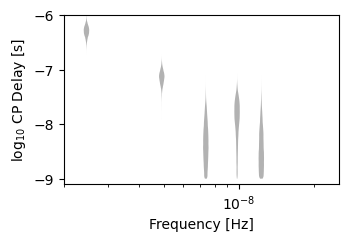

In [10]:
fig = plt.figure(figsize=[3.5503666805036667, 2.1942472810764047])
ax = fig.add_subplot(111)
vpt = ax.violinplot(NG_low, positions=(NG_freqs_5), widths=0.05*NG_freqs_5, showextrema=False)
ax.set_xscale('log')
for pc in vpt['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.3)

# Plot Labels
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'log$_{10}$ CP Delay [s]') # Residual [s]
plt.ylim(-9.1, -6)
plt.xlim(10**-8.7,10**-7.6)
#plt.legend(loc=9)

(1.9952623149688828e-09, 2.511886431509582e-08)

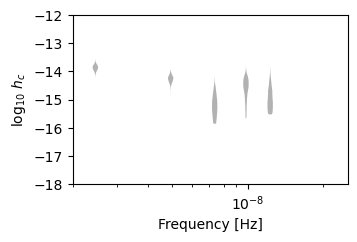

In [11]:
fig = plt.figure(figsize=[3.5503666805036667, 2.1942472810764047])
ax = fig.add_subplot(111)
vpt = ax.violinplot(hc_NG_low, positions=(NG_freqs_5), widths=0.05*NG_freqs_5, showextrema=False)
ax.set_xscale('log')
for pc in vpt['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.3)

# Plot Labels
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'log$_{10}$ $h_c$') # Characteristic strain 
plt.ylim(-18, -12)
plt.xlim(10**-8.7,10**-7.6)

In [9]:
filename = '../../../../NANOGrav_12p5/12p5yr_DE438_model2a_PSDspectrum_chain.hdf5'
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[1]
    
    # get the object type for a_group_key: usually group or dataset
    print(a_group_key, type(f[a_group_key]))
    
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    #ds_arr = f[a_group_key][()]  # returns as a numpy array
    
    print(type(ds_obj), ds_obj.shape)

Keys: <KeysViewHDF5 ['params', 'samples']>
samples <class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'> (1076200, 124)


In [10]:
h5file = h5py.File(filename, 'r')

log10_delay_samples = h5file['samples'][()][30000:]  # skipping the first 30000 rows from burn-in
type(log10_delay_samples), log10_delay_samples.shape

(numpy.ndarray, (1046200, 124))

In [11]:
Nsamples = len(log10_delay_samples[:, 0])
Nsamples_to_use = 10000

downsample = np.random.choice(np.arange(Nsamples), Nsamples_to_use, replace=False)
log10_delay_samples = log10_delay_samples[downsample,90:120]
log10_delay_samples_low = log10_delay_samples[:,:5]

In [12]:
log10_delay_samples_low, log10_delay_samples_low.shape

(array([[-6.3533647 , -7.21740164, -8.18535579, -8.81371299, -7.83128969],
        [-6.37769762, -7.23256444, -8.43634877, -7.52948021, -8.41511576],
        [-6.08962029, -7.20029014, -7.58640719, -8.82773812, -8.34490663],
        ...,
        [-6.55023139, -7.13164682, -8.54628888, -7.69324303, -8.49331879],
        [-6.46953362, -7.24305468, -8.03656592, -7.97974666, -8.80200486],
        [-6.20479056, -6.97587684, -7.8140067 , -7.9490738 , -8.57627967]]),
 (10000, 5))

dict_keys(['bodies', 'cmaxes', 'cmins', 'cbars'])


Text(0, 0.5, '$\\log_{10}$($d(f)$)')

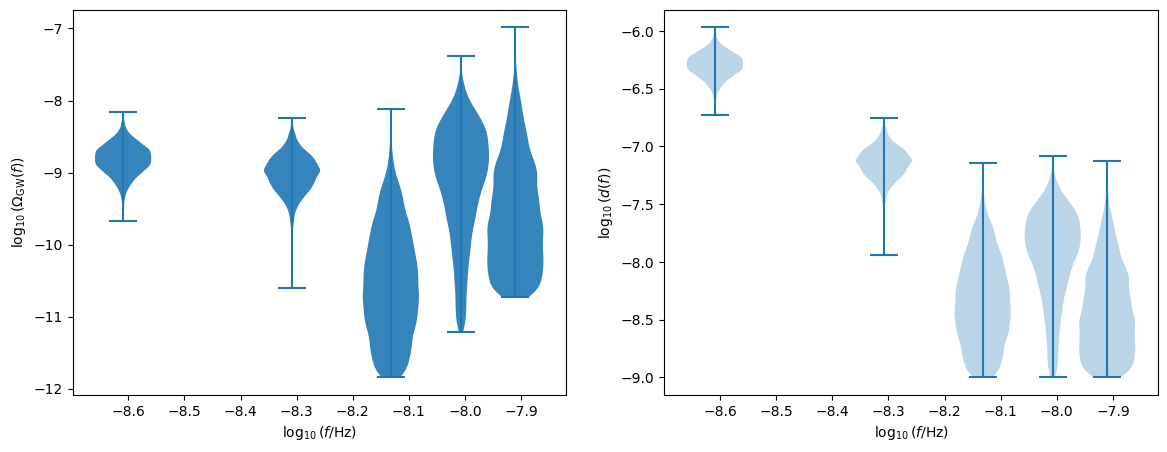

In [41]:
log10_Ogw_samples_low = 2*log10_delay_samples_low + np.log10(T_NG*8) + 4*np.log10(np.pi) + \
                        5*np.log10(NG_freqs_5) - 2*np.log10(cosmo.H0.to(u.Hz).value)

fig, (ax1, ax2,) = plt.subplots(1, 2, figsize=(14,5))
vp1 = ax1.violinplot(log10_Ogw_samples_low, 
               positions=np.log10(NG_freqs_5),
               widths=0.1)
ax1.set_xlabel(r'$\log_{10}$($f$/Hz)'); ax1.set_ylabel(r'$\log_{10}$($\Omega_{\rm GW}(f)$)')
print(vp1.keys())
for body in vp1['bodies']:
    body.set_alpha(0.9)

vp2 = ax2.violinplot(log10_delay_samples_low, 
               positions=np.log10(NG_freqs_5),
               widths=0.1)
ax2.set_xlabel(r'$\log_{10}$($f$/Hz)'); ax2.set_ylabel(r'$\log_{10}$($d(f)$)')
#plt.show()

In [70]:
IPTA_freqs_30 = np.array(open('../../../../iptadr2-free_spec_CP/crn_frequencies.txt', 'r').read().splitlines(), dtype=float)
T_IPTA = 1/IPTA_freqs_30[0]
IPTA_freqs_13 = IPTA_freqs_30[:13]
IPTA_freqs_13, T_IPTA

(array([1.04959728e-09, 2.13538757e-09, 3.22117786e-09, 4.30696815e-09,
        5.39275844e-09, 6.47854873e-09, 7.56433902e-09, 8.65012931e-09,
        9.73591960e-09, 1.08217099e-08, 1.19075002e-08, 1.29932905e-08,
        1.40790808e-08]),
 952746370.8571929)

In [71]:
IPTA_par_names = open('../../../../iptadr2-free_spec_CP/params_fs_CP.txt', 'r').read().splitlines()
len(IPTA_par_names), IPTA_par_names[245:]

(249, ['log_posterior', 'log_likelihood', 'mc_acceptance', 'pt_acceptance'])

In [72]:
IPTA = pd.read_csv('../../../../iptadr2-free_spec_CP/chain_fs_CP.txt', sep="\t", 
                 header=None, 
                 names=IPTA_par_names,
                 usecols=np.arange(215,245),
                 skiprows=160000,     # skip ~25% burn-in samples 
                )

IPTA = IPTA[::5]  # shrink the sample
IPTA.shape

(94080, 30)

In [73]:
Nsamples = len(np.array(IPTA)[:,0])
Nsamples_to_use = 10000

downsample = np.random.choice(np.arange(Nsamples), Nsamples_to_use, replace=False)
IPTA_samples = np.array(IPTA)[downsample,:]

In [74]:
IPTA_low = IPTA_samples[:,:13]
#IPTA_low = np.array(IPTA)[:,:13]
IPTA_low_med = np.median(IPTA_low, axis=0)
hc_IPTA_low = IPTA_low + (np.log10(T_IPTA*12*np.pi**2) + 3*np.log10(IPTA_freqs_13))/2
hc_IPTA_low_med = np.median(hc_IPTA_low, axis=0)
IPTA_low

array([[-7.02845953, -6.38432047, -6.43145442, ..., -8.9955194 ,
        -8.21126814, -8.16840162],
       [-6.94288008, -6.33957699, -6.4172115 , ..., -8.69664417,
        -8.57781278, -8.55194374],
       [-5.71896447, -6.34737382, -8.08267337, ..., -8.45909534,
        -8.60015569, -8.00378892],
       ...,
       [-7.79273672, -6.33231696, -6.28899053, ..., -8.7113101 ,
        -8.83588373, -7.92949426],
       [-5.96405714, -7.14878028, -6.13448965, ..., -8.60501869,
        -7.67596245, -7.58723035],
       [-7.02845953, -6.38432047, -6.43145442, ..., -8.9955194 ,
        -8.21126814, -8.16840162]])

(7.943282347242822e-10, 2.511886431509582e-08)

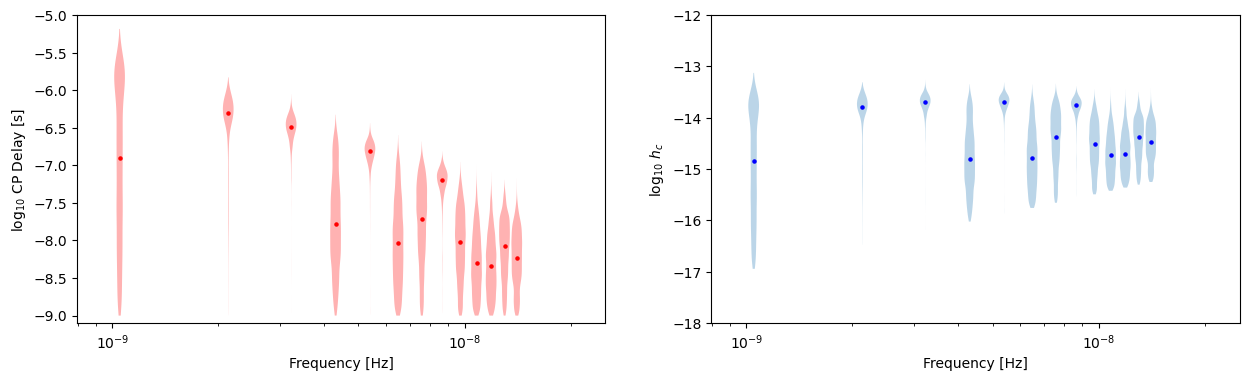

In [75]:
fig = plt.figure(figsize=[15, 4])
ax1 = fig.add_subplot(121)
vpt = ax1.violinplot(IPTA_low, positions=(IPTA_freqs_13), widths=0.07*IPTA_freqs_13, showextrema=False)
ax1.set_xscale('log')
for pc in vpt['bodies']:
    pc.set_facecolor('r')
    pc.set_alpha(0.3)
ax1.scatter(IPTA_freqs_13, IPTA_low_med, s=5, c='r',)
    
# Plot Labels
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'log$_{10}$ CP Delay [s]') # Residual [s]
plt.ylim(-9.1, -5)
plt.xlim(10**-9.1,10**-7.6)
#plt.legend(loc=9)

ax2 = fig.add_subplot(122)
vpt = ax2.violinplot(hc_IPTA_low, positions=(IPTA_freqs_13), widths=0.07*IPTA_freqs_13, showextrema=False)
ax2.set_xscale('log')
ax2.scatter(IPTA_freqs_13, hc_IPTA_low_med, s=5, c='b',)

# Plot Labels
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'log$_{10}$ $h_c$') # Characteristic strain 
plt.ylim(-18, -12)
plt.xlim(10**-9.1,10**-7.6)

Text(0, 0.5, '$\\log_{10}$($\\Omega_{\\rm GW}(f)$)')

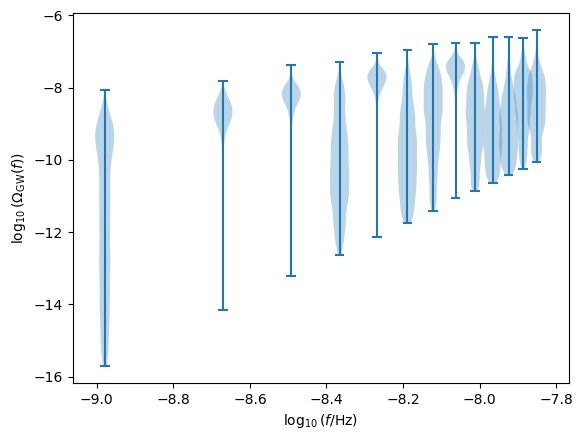

In [76]:
IPTA_Ogw_samples_low = 2*IPTA_low + np.log10(T_IPTA*8) + 4*np.log10(np.pi) + \
                        5*np.log10(IPTA_freqs_13) - 2*np.log10(cosmo.H0.to(u.Hz).value)

#plt.figure(figsize=[7, 7])
plt.violinplot(IPTA_Ogw_samples_low, 
               positions=np.log10(IPTA_freqs_13),
               widths=0.05)
plt.xlabel(r'$\log_{10}$($f$/Hz)'); plt.ylabel(r'$\log_{10}$($\Omega_{\rm GW}(f)$)')
#plt.xlim(-9.5, -7.5); plt.ylim(-9.5, -7.5)
#plt.show()

In [77]:
KDE = {i: kde(IPTA_Ogw_samples_low[:,i]) for i in range(13)}
type(KDE), KDE

(dict,
 {0: <scipy.stats._kde.gaussian_kde at 0x168995520>,
  1: <scipy.stats._kde.gaussian_kde at 0x168995880>,
  2: <scipy.stats._kde.gaussian_kde at 0x1689959d0>,
  3: <scipy.stats._kde.gaussian_kde at 0x168995c70>,
  4: <scipy.stats._kde.gaussian_kde at 0x168995b50>,
  5: <scipy.stats._kde.gaussian_kde at 0x168995820>,
  6: <scipy.stats._kde.gaussian_kde at 0x1689958b0>,
  7: <scipy.stats._kde.gaussian_kde at 0x168995b80>,
  8: <scipy.stats._kde.gaussian_kde at 0x168995ee0>,
  9: <scipy.stats._kde.gaussian_kde at 0x168995100>,
  10: <scipy.stats._kde.gaussian_kde at 0x168995be0>,
  11: <scipy.stats._kde.gaussian_kde at 0x1689951c0>,
  12: <scipy.stats._kde.gaussian_kde at 0x168995a90>})

In [78]:
IPTA_Ogw_low_limit = np.min(IPTA_Ogw_samples_low, axis=0)
print(IPTA_Ogw_low_limit,)
[KDE[i].logpdf(IPTA_Ogw_low_limit[i])[0] for i in range(13)]

[-15.70603091 -14.15410023 -13.20264674 -12.63947302 -12.12961641
 -11.75375895 -11.4166859  -11.05977986 -10.86938035 -10.63936174
 -10.43184167 -10.2423176  -10.06825968]


[-3.0928260784053507,
 -5.1559212401497945,
 -5.514459366192592,
 -3.0676887480862995,
 -5.119969708316695,
 -2.3235408712165655,
 -2.766381168476852,
 -5.221688215661615,
 -2.4042445228774283,
 -1.9826449627302412,
 -1.9527674459771232,
 -2.5374264362923333,
 -2.145433675514953]

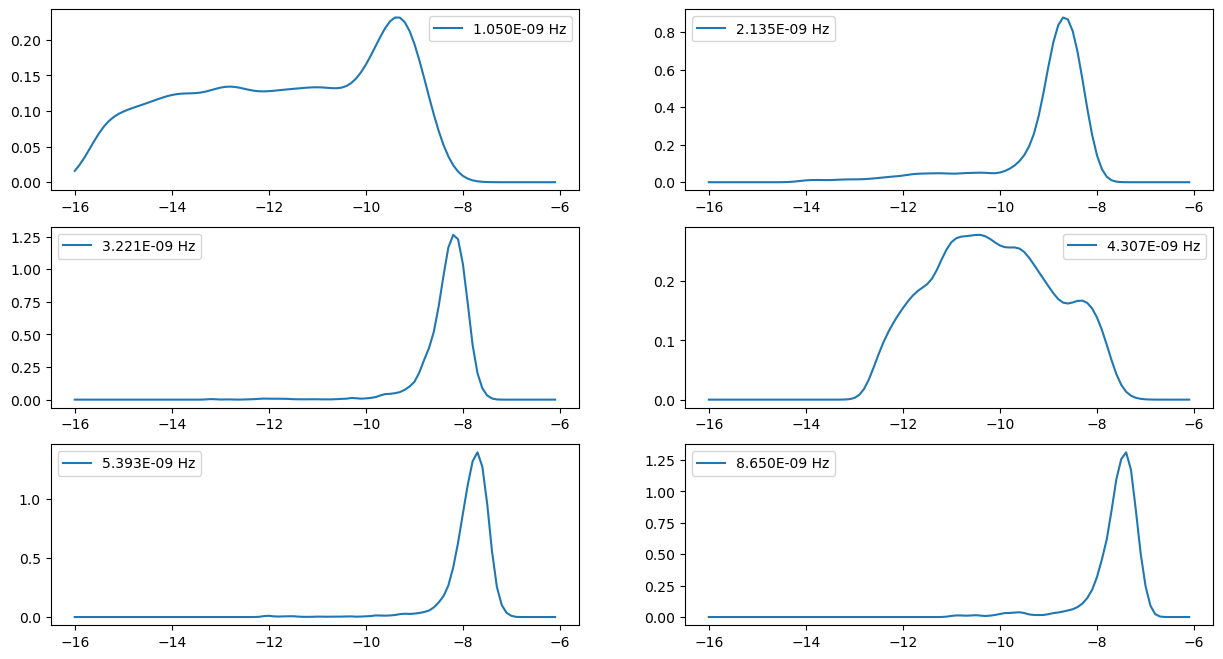

In [79]:
ogw = np.arange(-16, -6, .1)

fig, ((ax1, ax2,), (ax3, ax4,), (ax5, ax6),), = plt.subplots(3, 2,figsize=(15,8))
line1, = ax1.plot(ogw, np.exp(KDE[0].logpdf(ogw)), label=f"{IPTA_freqs_13[0]:.3E}"+' Hz'); ax1.legend(handles=[line1]) 
line2, = ax2.plot(ogw, np.exp(KDE[1].logpdf(ogw)), label=f"{IPTA_freqs_13[1]:.3E}"+' Hz'); ax2.legend(handles=[line2])  
line3, = ax3.plot(ogw, np.exp(KDE[2].logpdf(ogw)), label=f"{IPTA_freqs_13[2]:.3E}"+' Hz'); ax3.legend(handles=[line3]) 
line4, = ax4.plot(ogw, np.exp(KDE[3].logpdf(ogw)), label=f"{IPTA_freqs_13[3]:.3E}"+' Hz'); ax4.legend(handles=[line4]) 
line5, = ax5.plot(ogw, np.exp(KDE[4].logpdf(ogw)), label=f"{IPTA_freqs_13[4]:.3E}"+' Hz'); ax5.legend(handles=[line5]) 
line6, = ax6.plot(ogw, np.exp(KDE[7].logpdf(ogw)), label=f"{IPTA_freqs_13[7]:.3E}"+' Hz'); ax6.legend(handles=[line6]) 
plt.show()

In [199]:
IPTA_low_H02 = 2*IPTA_low + np.log10(T_IPTA*8) + 4*np.log10(np.pi) + 5*np.log10(IPTA_freqs_13)

np.savetxt('IPTA_dr2_low_H02.dat', IPTA_low_H02)

In [141]:
rho_HD = np.load('../../../../NANOGrav15yr/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{hd}_ceffyl/density.npy')
rhogrid_HD = np.load('../../../../NANOGrav15yr/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{hd}_ceffyl/log10rhogrid.npy')
bw_kde_HD = np.load('../../../../NANOGrav15yr/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{hd}_ceffyl/bandwidths.npy')

freqs_N15 = np.load('../../../../NANOGrav15yr/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{hd}_ceffyl/freqs.npy')
T_N15 = 1/freqs_N15[0]

rho_HD.shape, rhogrid_HD.shape, bw_kde_HD.shape, freqs_N15, T_N15/yr, np.log10(freqs_N15[:14])

((1, 30, 10000),
 (10000,),
 (30,),
 array([1.97682646e-09, 3.95365292e-09, 5.93047937e-09, 7.90730583e-09,
        9.88413229e-09, 1.18609587e-08, 1.38377852e-08, 1.58146117e-08,
        1.77914381e-08, 1.97682646e-08, 2.17450910e-08, 2.37219175e-08,
        2.56987439e-08, 2.76755704e-08, 2.96523969e-08, 3.16292233e-08,
        3.36060498e-08, 3.55828762e-08, 3.75597027e-08, 3.95365292e-08,
        4.15133556e-08, 4.34901821e-08, 4.54670085e-08, 4.74438350e-08,
        4.94206614e-08, 5.13974879e-08, 5.33743144e-08, 5.53511408e-08,
        5.73279673e-08, 5.93047937e-08]),
 16.029777268872294,
 array([-8.70403146, -8.40300146, -8.2269102 , -8.10197146, -8.00506145,
        -7.9258802 , -7.85893342, -7.80094147, -7.74978895, -7.70403146,
        -7.66263877, -7.62485021, -7.5900881 , -7.55790342]))

In [63]:
rhogrid_HD, rho_HD[0,0], rhogrid_HD.shape==rho_HD[0,0].shape, rho_HD[0,1]==rho_HD[0,2]

(array([-15.5       , -15.49854985, -15.49709971, ...,  -1.00290029,
         -1.00145015,  -1.        ]),
 array([ -4.77161076,  -4.69320401,  -4.62308551, ..., -36.04365339,
        -36.04365339, -36.04365339]),
 True,
 array([ True,  True,  True, ...,  True,  True,  True]))

In [64]:
delta_rhogrid = np.array([rhogrid_HD[i+1]-rhogrid_HD[i] for i in range(len(rhogrid_HD)-1)])
delta_rhogrid.shape, delta_rhogrid[0]==delta_rhogrid[-1], delta_rhogrid

((9999,),
 True,
 array([0.00145015, 0.00145015, 0.00145015, ..., 0.00145015, 0.00145015,
        0.00145015]))

In [150]:
rho_mock = np.copy(rho_HD)
#rho_mock.shape
log10freqbin = np.log10(freqs_N15)
slope = 3/2

for i in range(14):
    if i != 1:
        dis = round((log10freqbin[i]-log10freqbin[1]) * slope / .00145015)
        rho_mock[0,i,:]=rho_mock[0,1,0]
        if i>1:
            rho_mock[0,i,:-dis]=rho_mock[0,1,dis:]
        else:
            rho_mock[0,i,-dis:]=rho_mock[0,1,:dis]

np.save('NANOGrav15yr/density_mock.npy', rho_mock)

In [144]:
# Generate mock KDE for the time-delay spectrum with an arbitrary power law and Gaussian uncertainty

rho_HD = np.load('NANOGrav15yr/density.npy')
rhogrid_HD = np.load('NANOGrav15yr/log10rhogrid.npy')
freqs_N15 = np.load('NANOGrav15yr/freqs.npy')

rho_yr = -8.2; yr = (u.yr.to(u.s))
n = 2.; gamma = 5 - n
rho_spec = rho_yr - gamma/2. * np.log10(freqs_N15*yr)
#rho_spec.shape

rho_mk = np.copy(rho_HD)

sigma_rho = .02
for i in range(14):
    rho_mk[0,i,:] = norm.logpdf(rhogrid_HD, loc=rho_spec[i], scale=sigma_rho)

np.save('NANOGrav15yr/density_mk.npy', rho_mk)

In [110]:
rho_curn = np.load('../../../../NANOGrav15yr/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{cp}_ceffyl/density.npy')
rhogrid_curn = np.load('../../../../NANOGrav15yr/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{cp}_ceffyl/log10rhogrid.npy')
bw_kde_curn = np.load('../../../../NANOGrav15yr/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{cp}_ceffyl/bandwidths.npy')

rho_curn.shape, rhogrid_curn.shape, bw_kde_curn.shape

((1, 30, 10000), (10000,), (30,))

In [6]:
rhogrid_curn, rho_curn[0,0]

(array([-15.1       , -15.09857986, -15.09715972, ...,  -0.90284028,
         -0.90142014,  -0.9       ]),
 array([ -4.53755592,  -4.46619145,  -4.39403617, ..., -36.04365339,
        -36.04365339, -36.04365339]))

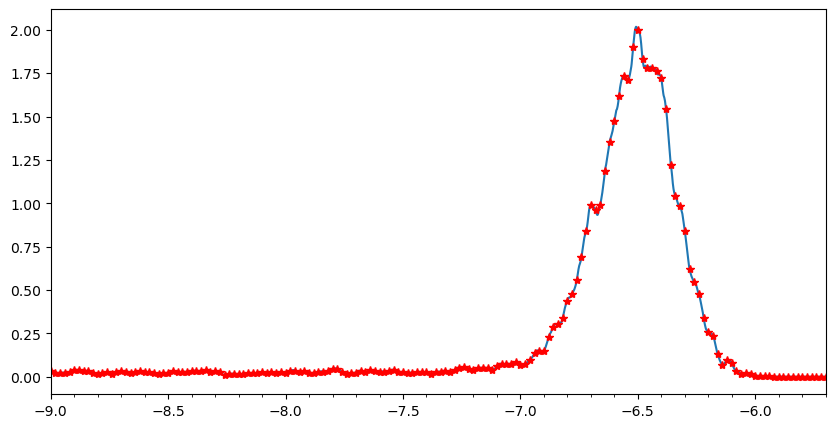

In [148]:
KDE_1 = interpolate.CubicSpline(rhogrid_HD, rho_HD[0,0])
rhogrid = np.arange(-9,-5.5,.02)

fig, ax1, = plt.subplots(1, 1,figsize=(10,5))

ax1.plot(rhogrid_HD, np.exp(rho_HD[0,0]), 'C0-',
         #rhogrid_HD, np.exp(rho_mk[0,0]), 'k-.',
        )
ax1.plot(rhogrid, np.exp(KDE_1(rhogrid)), 'r*')
ax1.set_xlim(-9, -5.7)
ax1.xaxis.set_minor_locator(MultipleLocator(.1))

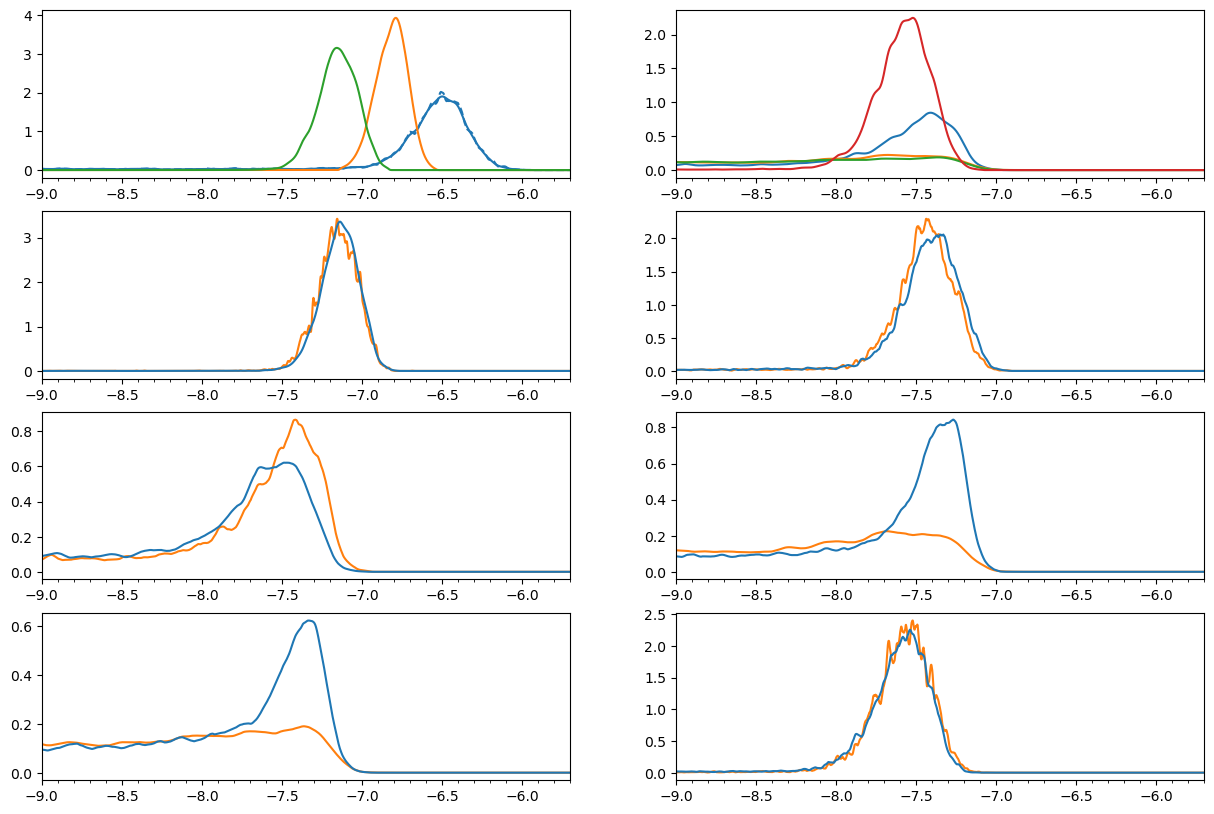

In [146]:
fig, ((ax1, ax2,), (ax3, ax4,), (ax5, ax6), (ax7, ax8)), = plt.subplots(4, 2,figsize=(15,10))

ax1.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,0],81)), 'C0-'); ax1.plot(rhogrid_HD, np.exp(rho_HD[0,0]), 'C0--'); 
ax1.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,1],81)), 'C1'); ax1.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,2],81)), 'C2')
#ax1.plot(rhogrid_HD, np.exp(smooth(rho_mock[0,0],81)), 'C0-'); ax1.plot(rhogrid_HD, np.exp(rho_mock[0,0]), 'C0--'); 
#ax1.plot(rhogrid_HD, np.exp(smooth(rho_mock[0,1],81)), 'C1'); ax1.plot(rhogrid_HD, np.exp(smooth(rho_mock[0,2],81)), 'C2')
#ax1.plot(rhogrid_HD, np.exp(rho_mk[0,1]), 'C1-.',); ax1.plot(rhogrid_HD, np.exp(rho_mk[0,2]), 'C2-.',)
ax1.set_xlim(-9, -5.7)
ax1.xaxis.set_minor_locator(MultipleLocator(.1))

ax2.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,4],81))); ax2.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,5],81))); 
ax2.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,6],81))); ax2.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,7],81)))
ax2.set_xlim(-9, -5.7)
ax2.xaxis.set_minor_locator(MultipleLocator(.1))

ax3.plot(rhogrid_HD, np.exp(smooth(rho_HD[0,2],11)), 'C1-'); ax3.plot(rhogrid_curn, np.exp(smooth(rho_curn[0,2],81)), 'C0-'); 
ax3.set_xlim(-9, -5.7)
ax3.xaxis.set_minor_locator(MultipleLocator(.1))

ax4.plot(rhogrid_HD, np.exp(rho_HD[0,3]), 'C1-'); ax4.plot(rhogrid_curn, np.exp(rho_curn[0,3]), 'C0-'); 
ax4.set_xlim(-9, -5.7)
ax4.xaxis.set_minor_locator(MultipleLocator(.1))

#ax3.plot(rhogrid_HD, np.exp(rho_HD[0,1]), 'C1-'); ax3.plot(rhogrid_curn, np.exp(rho_curn[0,1]), 'C0-'); 
ax5.plot(rhogrid_HD, np.exp(rho_HD[0,4]), 'C1-'); ax5.plot(rhogrid_curn, np.exp(rho_curn[0,4]), 'C0-'); 
ax5.set_xlim(-9, -5.7)
ax5.xaxis.set_minor_locator(MultipleLocator(.1))

ax6.plot(rhogrid_HD, np.exp(rho_HD[0,5]), 'C1-'); ax6.plot(rhogrid_curn, np.exp(rho_curn[0,5]), 'C0-'); 
ax6.set_xlim(-9, -5.7)
ax6.xaxis.set_minor_locator(MultipleLocator(.1))

ax7.plot(rhogrid_HD, np.exp(rho_HD[0,6]), 'C1-'); ax7.plot(rhogrid_curn, np.exp(rho_curn[0,6]), 'C0-'); 
ax7.set_xlim(-9, -5.7)
ax7.xaxis.set_minor_locator(MultipleLocator(.1))

ax8.plot(rhogrid_HD, np.exp(rho_HD[0,7]), 'C1-'); ax8.plot(rhogrid_curn, np.exp(rho_curn[0,7]), 'C0-'); 
ax8.set_xlim(-9, -5.7)
ax8.xaxis.set_minor_locator(MultipleLocator(.1))

In [129]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]

In [148]:
bin = 0
#KDE = interpolate.CubicSpline(rhogrid_HD, rho_HD[0, bin])
#out = get_output(prefix='chains/NG15_'+str(bin), resume=False, force=True)
KDE = interpolate.CubicSpline(rhogrid_HD, rho_mock[0, bin])
out = get_output(prefix='chains/NG15mock_'+str(bin), resume=False, force=True)

def NG15_like(log10rho):
    #devived = {"sum_a": a0 + a1}
    #KDE = interpolate.CubicSpline(rhogrid_HD, rho_HD[0,0])
    #logp = KDE(log10rho)+0
    return KDE(log10rho)+0

info = {
    'params': {
        'log10rho': {
            'prior': {'min': -9., 'max': -4.},
            'ref': {'dist': 'uniform', 'loc': -9, 'scale': 2},
            'proposal': 0.1,
        }, 
    }, 
    'likelihood': {
        'NG15': {'external': NG15_like,
                 #'input_params': ['log10rho'], 
                },
    },
}
print(info)

model = get_model(info)
print(list(model.parameterization.sampled_params()))

model.logposterior({'log10rho': -6,}, as_dict=True,)

[output] Output to be read-from/written-into folder 'chains', with prefix 'NG15mock_0'
[output] Found existing info files with the requested output prefix: 'chains/NG15mock_0'
[output] Will delete previous products ('force' was requested).
{'params': {'log10rho': {'prior': {'min': -9.0, 'max': -4.0}, 'ref': {'dist': 'uniform', 'loc': -9, 'scale': 2}, 'proposal': 0.1}}, 'likelihood': {'NG15': {'external': <function NG15_like at 0x1538e1ee0>}}}
[ng15] Initialized external likelihood.
['log10rho']


{'logpost': -8.445609715683817,
 'logpriors': {'0': -1.6094379124341003},
 'loglikes': {'NG15': -6.836171803249717},
 'derived': {}}

In [149]:
info_sampler = {"mcmc": {"max_tries": '300d', 'max_samples': 45000,
                         "Rminus1_stop": 0.0001, 'Rminus1_cl_stop': 0.001}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model, output=out)
mcmc.run()

[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: log10rho:-8.383903
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {NG15: 79600.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-03-10 21:12:22 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.492
[mcmc]  - Convergence of means: R-1 = 0.141937 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.489
[mcmc]  - Convergence of means: R-1 = 0.540990 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.482
[mcmc]  - Convergence of means: R-

In [152]:
#NG15 = np.loadtxt('chains/NG15_0.1.txt')
NG15 = np.loadtxt('chains/NG15mock_0.1.txt')
NG15 = NG15[NG15.shape[0]-30000:,2]
NG15 = np.expand_dims(NG15, axis=0)

for i in range(13):
    #chainfile = 'chains/NG15_'+str(i+1)+'.1.txt'
    chainfile = 'chains/NG15mock_'+str(i+1)+'.1.txt'
    chain = np.loadtxt(chainfile)
    chainlen = chain.shape[0]
    #print(chainlen)
    chain = chain[chainlen-30000:,2]
    chain = np.expand_dims(chain, axis=0)
    NG15 = np.concatenate((NG15, chain,), axis=0)
    
NG15 = NG15.T; print(NG15.shape)
#np.savetxt('NANOGrav15yr/sample.txt', NG15)
np.savetxt('NANOGrav15yr/sample_mock.txt', NG15)

(30000, 14)


In [75]:
NG15 = np.loadtxt('NANOGrav15yr/sample.txt')
NG15_mock = np.loadtxt('NANOGrav15yr/sample_mock.txt')

NGfreqs = np.log10(freqs_N15[:14])
hc_NG15 = NG15 + np.log10(T_N15*12*np.pi**2)/2 + 1.5*NGfreqs
Ogw_NG15 = 2*NG15 + np.log10(T_N15*8) + 4*np.log10(np.pi) + 5*NGfreqs - 2*np.log10(cosmo.H0.to(u.Hz).value)
NGfreqs

array([-8.70403146, -8.40300146, -8.2269102 , -8.10197146, -8.00506145,
       -7.9258802 , -7.85893342, -7.80094147, -7.74978895, -7.70403146,
       -7.66263877, -7.62485021, -7.5900881 , -7.55790342])

(-16.0, -3.0)

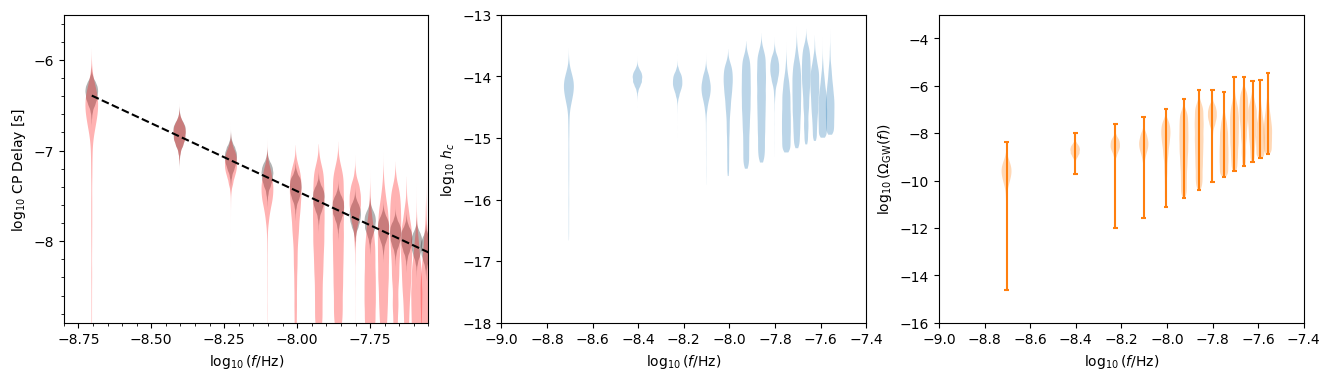

In [149]:
fig = plt.figure(figsize=[16, 4])

ax1 = fig.add_subplot(131)
ax1.plot(np.log10(freqs_N15), rho_spec, color='k', ls='--')
ax1.axvline(-np.log10(yr), color='k', ls='--')
#ax1.set_xscale('log')
vpt = ax1.violinplot(NG15_mock, positions=(NGfreqs), widths=5e-3*np.abs(NGfreqs), showextrema=False)
vpt1 = ax1.violinplot(NG15, positions=(NGfreqs), widths=5e-3*np.abs(NGfreqs), showextrema=False)
for pc in vpt['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.3)
for pc in vpt1['bodies']:
    pc.set_facecolor('r')
    pc.set_alpha(0.3)
#ax1.scatter(IPTA_freqs_13, IPTA_low_med, s=5, c='r',)
plt.xlabel(r'$\log_{10}(f/\mathrm{Hz})$');
plt.ylabel(r'log$_{10}$ CP Delay [s]') # Residual [s]
plt.xlim(-8.8, -7.55); plt.ylim(-8.9, -5.5)
#plt.legend(loc=9)
ax1.set_xticks(np.arange(-8.75,-7.5,.25), minor=False)
ax1.xaxis.set_minor_locator(MultipleLocator(.05))
ax1.set_yticks(np.arange(-8,-5,1), minor=False)
ax1.yaxis.set_minor_locator(MultipleLocator(.2))

ax2 = fig.add_subplot(132)
vpt2 = ax2.violinplot(hc_NG15, positions=(NGfreqs), widths=5e-3*np.abs(NGfreqs), showextrema=False,)
#ax2.set_xscale('log')
#ax2.scatter(IPTA_freqs_13, hc_IPTA_low_med, s=5, c='b',)
plt.xlabel(r'$\log_{10}(f/\mathrm{Hz})$')
plt.ylabel(r'log$_{10}$ $h_c$') # Characteristic strain 
plt.xlim(-9, -7.4); plt.ylim(-18, -13.)

ax3 = fig.add_subplot(133)
vpt3 = ax3.violinplot(Ogw_NG15, positions=(NGfreqs), widths=5e-3*np.abs(NGfreqs), showextrema=True,)
vpt3['cbars'].set_color('tab:orange')
vpt3['cmaxes'].set_color('tab:orange')
vpt3['cmins'].set_color('tab:orange')
for pc in vpt3['bodies']:
    pc.set_facecolor('tab:orange')
    pc.set_alpha(0.3)
plt.xlabel(r'$\log_{10}(f/\mathrm{Hz})$')
plt.ylabel(r'$\log_{10}$($\Omega_{\rm GW}(f)$)')
plt.xlim(-9, -7.4); plt.ylim(-16, -3)

In [17]:
EPTA_freqsnew = np.loadtxt('../../../../EPTA-dr2/epta-dr2-master-EPTA-DR2-scripts_gwb-freq_bins/EPTA-DR2/scripts_gwb/freq_bins/freqs_dr2new.txt')
T_EPTA = 1/EPTA_freqsnew[0]
EPTA_freqsnew, T_EPTA/yr

(array([3.06632209e-09, 6.13264419e-09, 9.19896628e-09, 1.22652884e-08,
        1.53316105e-08, 1.83979326e-08, 2.14642547e-08, 2.45305768e-08,
        2.75968988e-08, 3.06632209e-08, 3.37295430e-08, 3.67958651e-08,
        3.98621872e-08, 4.29285093e-08, 4.59948314e-08, 4.90611535e-08,
        5.21274756e-08, 5.51937977e-08, 5.82601198e-08, 6.13264419e-08]),
 10.334233275027252)

In [18]:
EPTAnew_par_names = open('../../../../EPTA-dr2/chains/chains/DR2new/hd_fs/pars.txt', 'r').read().splitlines()
len(EPTAnew_par_names), EPTAnew_par_names[65:]

(85,
 ['gw_hd_log10_rho_0',
  'gw_hd_log10_rho_1',
  'gw_hd_log10_rho_2',
  'gw_hd_log10_rho_3',
  'gw_hd_log10_rho_4',
  'gw_hd_log10_rho_5',
  'gw_hd_log10_rho_6',
  'gw_hd_log10_rho_7',
  'gw_hd_log10_rho_8',
  'gw_hd_log10_rho_9',
  'gw_hd_log10_rho_10',
  'gw_hd_log10_rho_11',
  'gw_hd_log10_rho_12',
  'gw_hd_log10_rho_13',
  'gw_hd_log10_rho_14',
  'gw_hd_log10_rho_15',
  'gw_hd_log10_rho_16',
  'gw_hd_log10_rho_17',
  'gw_hd_log10_rho_18',
  'gw_hd_log10_rho_19'])

In [19]:
EPTAnew = pd.read_csv('../../../../EPTA-dr2/chains/chains/DR2new/hd_fs/chain_1.txt', sep="\t", 
                 header=None, 
                 names=EPTAnew_par_names+['log_posterior', 'log_likelihood', 'mc_acceptance', 'pt_acceptance'],
                 usecols=np.arange(65,74),
                 #skiprows=160000,
                )
EPTAnew

,gw_hd_log10_rho_0,gw_hd_log10_rho_1,gw_hd_log10_rho_2,gw_hd_log10_rho_3,gw_hd_log10_rho_4,gw_hd_log10_rho_5,gw_hd_log10_rho_6,gw_hd_log10_rho_7,gw_hd_log10_rho_8
0,-7.104153,-8.176560,-4.747679,-6.445927,-7.791525,-4.791380,-6.736580,-6.450789,-6.173228
1,-7.104153,-7.140620,-4.747679,-6.445927,-7.791525,-4.791380,-6.736580,-4.126081,-6.173228
2,-7.104153,-7.126965,-4.747679,-6.445927,-7.791525,-4.791380,-6.736580,-4.126081,-6.173228
3,-7.104153,-7.126965,-9.574363,-6.445927,-7.791525,-4.791380,-6.736580,-4.126081,-6.173228
4,-7.100775,-7.128420,-9.576510,-6.442495,-7.792649,-8.838347,-6.730275,-4.918338,-6.176880
...,...,...,...,...,...,...,...,...,...
29985,-6.601767,-6.901747,-8.774693,-7.266833,-8.581170,-8.236332,-8.535896,-9.732572,-8.492678
29986,-6.611064,-6.912619,-8.873210,-7.290399,-8.654349,-8.207201,-8.472417,-9.751807,-8.041929
29987,-6.612157,-6.912213,-8.863129,-7.291660,-8.650406,-8.438506,-8.476165,-8.257127,-8.048617
29988,-6.645173,-6.910538,-8.832353,-7.300863,-8.637687,-8.531342,-9.604430,-8.329955,-8.080563


In [21]:
freqs = np.log10(EPTA_freqsnew[:9])
hc_EPTA = EPTAnew + np.log10(T_EPTA*12*np.pi**2)/2 + 1.5*freqs
Ogw_EPTA = 2*EPTAnew + np.log10(T_EPTA*8) + 4*np.log10(np.pi) + 5*freqs - 2*np.log10(cosmo.H0.to(u.Hz).value)

(-16.0, -3.0)

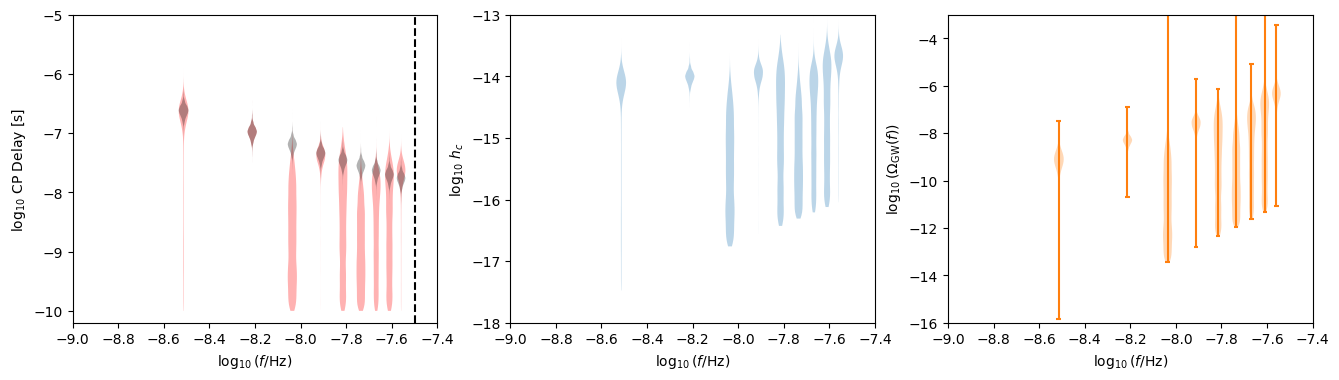

In [55]:
fig = plt.figure(figsize=[16, 4])

ax1 = fig.add_subplot(131)
ax1.axvline(-np.log10(yr), color='k', ls='--')
#ax1.set_xscale('log')
vpt1 = ax1.violinplot(EPTAnew, positions=(freqs), widths=5e-3*np.abs(freqs), showextrema=False)
for pc in vpt1['bodies']:
    pc.set_facecolor('r')
    pc.set_alpha(0.3)
vpt1_mk = ax1.violinplot(EPTAnew_mock, positions=(freqs), widths=5e-3*np.abs(freqs), showextrema=False)
for pc in vpt1_mk['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.3)
#ax1.scatter(IPTA_freqs_13, IPTA_low_med, s=5, c='r',)
plt.xlabel(r'$\log_{10}(f/\mathrm{Hz})$');
plt.ylabel(r'log$_{10}$ CP Delay [s]') # Residual [s]
plt.xlim(-9, -7.4); plt.ylim(-10.2, -5)
#plt.legend(loc=9)

ax2 = fig.add_subplot(132)
vpt2 = ax2.violinplot(hc_EPTA, positions=(freqs), widths=5e-3*np.abs(freqs), showextrema=False,)
#ax2.set_xscale('log')
#ax2.scatter(IPTA_freqs_13, hc_IPTA_low_med, s=5, c='b',)
plt.xlabel(r'$\log_{10}(f/\mathrm{Hz})$')
plt.ylabel(r'log$_{10}$ $h_c$') # Characteristic strain 
plt.xlim(-9, -7.4); plt.ylim(-18, -13.)

ax3 = fig.add_subplot(133)
vpt3 = ax3.violinplot(Ogw_EPTA, positions=(freqs), widths=5e-3*np.abs(freqs), showextrema=True,)
vpt3['cbars'].set_color('tab:orange')
vpt3['cmaxes'].set_color('tab:orange')
vpt3['cmins'].set_color('tab:orange')
for pc in vpt3['bodies']:
    pc.set_facecolor('tab:orange')
    pc.set_alpha(0.3)
plt.xlabel(r'$\log_{10}(f/\mathrm{Hz})$')
plt.ylabel(r'$\log_{10}$($\Omega_{\rm GW}(f)$)')
plt.xlim(-9, -7.4); plt.ylim(-16, -3)

In [253]:
#OgwH2_EPTA = 2*EPTAnew + np.log10(T_EPTA*8) + 4*np.log10(np.pi) + 5*freqs

np.savetxt('EPTAdr2/EPTA_dr2new.dat', EPTAnew)

In [54]:
EPTAnew_mock = EPTAnew.copy(deep=True) 
#EPTAnew_mock
log10freqbin = np.log10(EPTA_freqsnew)
slope = (2.6-5)/2

for i in range(9):
    if i != 1:
        Delta_rho = (log10freqbin[i]-log10freqbin[1]) * slope 
        EPTAnew_mock['gw_hd_log10_rho_'+str(i)] = EPTAnew_mock['gw_hd_log10_rho_1'] + Delta_rho

#EPTAnew_mock
np.savetxt('EPTAdr2/EPTA_dr2new_mock.dat', EPTAnew_mock)

In [32]:
info = {
#    'params': {}, 
    'likelihood': {
        'NANOGrav_BH': {'python_path': '.'},
    },
}

from cobaya.model import get_model
model = get_model(info)

#model.logposterior({'A_BBH': -15, 'gamma_BBH': 13/3}, as_dict=True,)

from cobaya.output import get_output
out = get_output(prefix="chains/NG_SMBHB", resume=False, force=True)

info_sampler = {"mcmc": {"Rminus1_stop": 0.005, 'Rminus1_cl_stop': 0.1}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model, output=out)
mcmc.run()

INFO:output:Output to be read-from/written-into folder 'chains', with prefix 'NG_SMBHB'


[output] Output to be read-from/written-into folder 'chains', with prefix 'NG_SMBHB'


INFO:output:Found existing info files with the requested output prefix: 'chains/NG_SMBHB'


[output] Found existing info files with the requested output prefix: 'chains/NG_SMBHB'


INFO:output:Will delete previous products ('force' was requested).


[output] Will delete previous products ('force' was requested).


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {NANOGrav_BH: 222.0}


[model] Setting measured speeds (per sec): {NANOGrav_BH: 222.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Initial point: A_BBH:-15.30687, gamma_BBH:4.675769


[mcmc] Initial point: A_BBH:-15.30687, gamma_BBH:4.675769


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2023-07-27 14:40:40 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2023-07-27 14:40:40 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 80 samples accepted.


[mcmc] Learn + convergence test @ 80 samples accepted.


INFO:mcmc: - Acceptance rate: 0.736


[mcmc]  - Acceptance rate: 0.736


INFO:mcmc: - Convergence of means: R-1 = 12.706643 after 64 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.706643 after 64 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160 samples accepted.


[mcmc] Learn + convergence test @ 160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.634


[mcmc]  - Acceptance rate: 0.634


INFO:mcmc: - Convergence of means: R-1 = 3.452700 after 128 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.452700 after 128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.449


[mcmc]  - Acceptance rate: 0.449


INFO:mcmc: - Convergence of means: R-1 = 1.760231 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.760231 after 192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.369


[mcmc]  - Acceptance rate: 0.369


INFO:mcmc: - Convergence of means: R-1 = 1.793755 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.793755 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400 samples accepted.


[mcmc] Learn + convergence test @ 400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.312


[mcmc]  - Acceptance rate: 0.312


INFO:mcmc: - Convergence of means: R-1 = 5.258087 after 320 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.258087 after 320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.969411 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.969411 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 560 samples accepted.


[mcmc] Learn + convergence test @ 560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.276


[mcmc]  - Acceptance rate: 0.276


INFO:mcmc: - Convergence of means: R-1 = 0.441330 after 448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.441330 after 448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.257


[mcmc]  - Acceptance rate: 0.257


INFO:mcmc: - Convergence of means: R-1 = 0.261443 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.261443 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.255


[mcmc]  - Acceptance rate: 0.255


INFO:mcmc: - Convergence of means: R-1 = 0.109881 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109881 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.241


[mcmc]  - Acceptance rate: 0.241


INFO:mcmc: - Convergence of means: R-1 = 0.051152 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051152 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 880 samples accepted.


[mcmc] Learn + convergence test @ 880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.248


[mcmc]  - Acceptance rate: 0.248


INFO:mcmc: - Convergence of means: R-1 = 0.027902 after 704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027902 after 704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.248


[mcmc]  - Acceptance rate: 0.248


INFO:mcmc: - Convergence of means: R-1 = 0.031753 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031753 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1040 samples accepted.


[mcmc] Learn + convergence test @ 1040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.250


[mcmc]  - Acceptance rate: 0.250


INFO:mcmc: - Convergence of means: R-1 = 0.017663 after 832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017663 after 832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.251


[mcmc]  - Acceptance rate: 0.251


INFO:mcmc: - Convergence of means: R-1 = 0.010651 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010651 after 896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.253


[mcmc]  - Acceptance rate: 0.253


INFO:mcmc: - Convergence of means: R-1 = 0.024698 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024698 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.256


[mcmc]  - Acceptance rate: 0.256


INFO:mcmc: - Convergence of means: R-1 = 0.034323 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034323 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1360 samples accepted.


[mcmc] Learn + convergence test @ 1360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.256


[mcmc]  - Acceptance rate: 0.256


INFO:mcmc: - Convergence of means: R-1 = 0.018259 after 1088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018259 after 1088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.259


[mcmc]  - Acceptance rate: 0.259


INFO:mcmc: - Convergence of means: R-1 = 0.012788 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012788 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1520 samples accepted.


[mcmc] Learn + convergence test @ 1520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.260


[mcmc]  - Acceptance rate: 0.260


INFO:mcmc: - Convergence of means: R-1 = 0.023953 after 1216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023953 after 1216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.261


[mcmc]  - Acceptance rate: 0.261


INFO:mcmc: - Convergence of means: R-1 = 0.019927 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019927 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1680 samples accepted.


[mcmc] Learn + convergence test @ 1680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.264


[mcmc]  - Acceptance rate: 0.264


INFO:mcmc: - Convergence of means: R-1 = 0.021354 after 1344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021354 after 1344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.265


[mcmc]  - Acceptance rate: 0.265


INFO:mcmc: - Convergence of means: R-1 = 0.007257 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007257 after 1408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1840 samples accepted.


[mcmc] Learn + convergence test @ 1840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.266


[mcmc]  - Acceptance rate: 0.266


INFO:mcmc: - Convergence of means: R-1 = 0.006867 after 1472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006867 after 1472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.265


[mcmc]  - Acceptance rate: 0.265


INFO:mcmc: - Convergence of means: R-1 = 0.005311 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005311 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.266


[mcmc]  - Acceptance rate: 0.266


INFO:mcmc: - Convergence of means: R-1 = 0.002917 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002917 after 1600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2080 samples accepted.


[mcmc] Learn + convergence test @ 2080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.268


[mcmc]  - Acceptance rate: 0.268


INFO:mcmc: - Convergence of means: R-1 = 0.004515 after 1664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004515 after 1664 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.099126 after 2080 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.099126 after 2080 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 2080 accepted steps.


[mcmc] Sampling complete after 2080 accepted steps.


In [57]:
info = {
#    'params': {}, 
    'likelihood': {
        'IPTA_BH': {'python_path': '.'},
    },
}

from cobaya.model import get_model
model = get_model(info)

#model.logposterior({'A_BBH': -15, 'gamma_BBH': 13/3}, as_dict=True,)

from cobaya.output import get_output
out = get_output(prefix="chains/EPTA_SMBHB", resume=False, force=True)

info_sampler = {"mcmc": {"Rminus1_stop": 0.005, 'Rminus1_cl_stop': 0.1}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model, output=out)
mcmc.run()

INFO:output:Output to be read-from/written-into folder 'chains', with prefix 'EPTA_SMBHB'


[output] Output to be read-from/written-into folder 'chains', with prefix 'EPTA_SMBHB'


INFO:output:Found existing info files with the requested output prefix: 'chains/EPTA_SMBHB'


[output] Found existing info files with the requested output prefix: 'chains/EPTA_SMBHB'


INFO:output:Will delete previous products ('force' was requested).


[output] Will delete previous products ('force' was requested).


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {IPTA_BH: 26.0}


[model] Setting measured speeds (per sec): {IPTA_BH: 26.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Initial point: A_BBH:-15.07876, gamma_BBH:4.685464


[mcmc] Initial point: A_BBH:-15.07876, gamma_BBH:4.685464


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2023-07-27 14:54:13 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2023-07-27 14:54:13 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 80 samples accepted.


[mcmc] Learn + convergence test @ 80 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 8.464936 after 64 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.464936 after 64 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160 samples accepted.


[mcmc] Learn + convergence test @ 160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.826


[mcmc]  - Acceptance rate: 0.826


INFO:mcmc: - Convergence of means: R-1 = 2.711628 after 128 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.711628 after 128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.580


[mcmc]  - Acceptance rate: 0.580


INFO:mcmc: - Convergence of means: R-1 = 6.988146 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.988146 after 192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.485


[mcmc]  - Acceptance rate: 0.485


INFO:mcmc: - Convergence of means: R-1 = 3.436923 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.436923 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400 samples accepted.


[mcmc] Learn + convergence test @ 400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.392


[mcmc]  - Acceptance rate: 0.392


INFO:mcmc: - Convergence of means: R-1 = 4.125492 after 320 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.125492 after 320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2023-07-27 14:55:13 : 1095 steps taken, and 456 accepted.


[mcmc] Progress @ 2023-07-27 14:55:13 : 1095 steps taken, and 456 accepted.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.358


[mcmc]  - Acceptance rate: 0.358


INFO:mcmc: - Convergence of means: R-1 = 0.544509 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.544509 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 560 samples accepted.


[mcmc] Learn + convergence test @ 560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.198784 after 448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.198784 after 448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.048781 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048781 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.293


[mcmc]  - Acceptance rate: 0.293


INFO:mcmc: - Convergence of means: R-1 = 0.021335 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021335 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2023-07-27 14:56:13 : 2282 steps taken, and 755 accepted.


[mcmc] Progress @ 2023-07-27 14:56:13 : 2282 steps taken, and 755 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.286


[mcmc]  - Acceptance rate: 0.286


INFO:mcmc: - Convergence of means: R-1 = 0.010336 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010336 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 880 samples accepted.


[mcmc] Learn + convergence test @ 880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.284


[mcmc]  - Acceptance rate: 0.284


INFO:mcmc: - Convergence of means: R-1 = 0.004992 after 704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004992 after 704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.284


[mcmc]  - Acceptance rate: 0.284


INFO:mcmc: - Convergence of means: R-1 = 0.008287 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008287 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1040 samples accepted.


[mcmc] Learn + convergence test @ 1040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.280


[mcmc]  - Acceptance rate: 0.280


INFO:mcmc: - Convergence of means: R-1 = 0.006258 after 832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006258 after 832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2023-07-27 14:57:13 : 3414 steps taken, and 1066 accepted.


[mcmc] Progress @ 2023-07-27 14:57:13 : 3414 steps taken, and 1066 accepted.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.276


[mcmc]  - Acceptance rate: 0.276


INFO:mcmc: - Convergence of means: R-1 = 0.003709 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003709 after 896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.275


[mcmc]  - Acceptance rate: 0.275


INFO:mcmc: - Convergence of means: R-1 = 0.012038 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012038 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.272


[mcmc]  - Acceptance rate: 0.272


INFO:mcmc: - Convergence of means: R-1 = 0.008191 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008191 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1360 samples accepted.


[mcmc] Learn + convergence test @ 1360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.272


[mcmc]  - Acceptance rate: 0.272


INFO:mcmc: - Convergence of means: R-1 = 0.002823 after 1088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002823 after 1088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2023-07-27 14:58:13 : 4588 steps taken, and 1396 accepted.


[mcmc] Progress @ 2023-07-27 14:58:13 : 4588 steps taken, and 1396 accepted.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.271


[mcmc]  - Acceptance rate: 0.271


INFO:mcmc: - Convergence of means: R-1 = 0.004540 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.004540 after 1152 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.067158 after 1440 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.067158 after 1440 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 1440 accepted steps.


[mcmc] Sampling complete after 1440 accepted steps.


In [51]:
fiducial_params = {'A_BBH': {'prior': {'min': -18, 'max': -11}, 'latex': '\log_{10}\,h_{c,\mathrm{BH}}'}, 
                   'gamma_BBH': {'prior': {'min': 0, 'max': 7},
                                 #'value': 13/3,
                                 'latex': '\gamma_\mathrm{BH}'
                   }, 
                  }
info = {
    'params': fiducial_params,
    'likelihood': {'one':{}},
    'prior': {'GWOnly-Ext': lambda A_BBH, gamma_BBH: multivariate_normal.logpdf(
          [A_BBH, gamma_BBH], mean=[-15.6, 4.7], cov=[[0.28, -0.0026], [-0.0026, 0.12]])}
}

from cobaya.model import get_model
model = get_model(info)

from cobaya.output import get_output
out = get_output(prefix="chains/prior_test", resume=False, force=True)

info_sampler = {"mcmc": {"Rminus1_stop": 0.005, 'Rminus1_cl_stop': 0.1}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model, output=out)
mcmc.run()

[prior] *WARNING* External prior 'GWOnly-Ext' loaded. Mind that it might not be normalized!


INFO:output:Output to be read-from/written-into folder 'chains', with prefix 'prior_test'


[output] Output to be read-from/written-into folder 'chains', with prefix 'prior_test'


INFO:output:Found existing info files with the requested output prefix: 'chains/prior_test'


[output] Found existing info files with the requested output prefix: 'chains/prior_test'


INFO:output:Will delete previous products ('force' was requested).


[output] Will delete previous products ('force' was requested).


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:prior:Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.


[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {one: 10000000.0}


[model] Setting measured speeds (per sec): {one: 10000000.0}


[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Initial point: A_BBH:-13.57136, gamma_BBH:0.03454399


[mcmc] Initial point: A_BBH:-13.57136, gamma_BBH:0.03454399


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2023-07-27 14:52:20 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2023-07-27 14:52:20 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 80 samples accepted.


[mcmc] Learn + convergence test @ 80 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.164859 after 64 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164859 after 64 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160 samples accepted.


[mcmc] Learn + convergence test @ 160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.178460 after 128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178460 after 128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.267


[mcmc]  - Acceptance rate: 0.267


INFO:mcmc: - Convergence of means: R-1 = 0.195676 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195676 after 192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.314


[mcmc]  - Acceptance rate: 0.314


INFO:mcmc: - Convergence of means: R-1 = 0.129902 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129902 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400 samples accepted.


[mcmc] Learn + convergence test @ 400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.355


[mcmc]  - Acceptance rate: 0.355


INFO:mcmc: - Convergence of means: R-1 = 0.051759 after 320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051759 after 320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.327


[mcmc]  - Acceptance rate: 0.327


INFO:mcmc: - Convergence of means: R-1 = 0.059388 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059388 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 560 samples accepted.


[mcmc] Learn + convergence test @ 560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.321


[mcmc]  - Acceptance rate: 0.321


INFO:mcmc: - Convergence of means: R-1 = 0.039632 after 448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039632 after 448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.325


[mcmc]  - Acceptance rate: 0.325


INFO:mcmc: - Convergence of means: R-1 = 0.087081 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087081 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.314


[mcmc]  - Acceptance rate: 0.314


INFO:mcmc: - Convergence of means: R-1 = 0.012886 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012886 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.314


[mcmc]  - Acceptance rate: 0.314


INFO:mcmc: - Convergence of means: R-1 = 0.021041 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021041 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 880 samples accepted.


[mcmc] Learn + convergence test @ 880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.312


[mcmc]  - Acceptance rate: 0.312


INFO:mcmc: - Convergence of means: R-1 = 0.014159 after 704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014159 after 704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.309


[mcmc]  - Acceptance rate: 0.309


INFO:mcmc: - Convergence of means: R-1 = 0.039913 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039913 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1040 samples accepted.


[mcmc] Learn + convergence test @ 1040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.027213 after 832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027213 after 832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.019363 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019363 after 896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.022040 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022040 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016833 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016833 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1360 samples accepted.


[mcmc] Learn + convergence test @ 1360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.293


[mcmc]  - Acceptance rate: 0.293


INFO:mcmc: - Convergence of means: R-1 = 0.017474 after 1088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017474 after 1088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.006845 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006845 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1520 samples accepted.


[mcmc] Learn + convergence test @ 1520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010057 after 1216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010057 after 1216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.020400 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020400 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1680 samples accepted.


[mcmc] Learn + convergence test @ 1680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.009602 after 1344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009602 after 1344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.005203 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.005203 after 1408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1840 samples accepted.


[mcmc] Learn + convergence test @ 1840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.003691 after 1472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.003691 after 1472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.002341 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.002341 after 1536 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.089273 after 1920 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.089273 after 1920 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 1920 accepted steps.


[mcmc] Sampling complete after 1920 accepted steps.


In [80]:
EPTAnew_pl_par = open('../../../../EPTA-dr2/chains/chains/DR2new/hd_pl/pars.txt', 'r').read().splitlines()
print(len(EPTAnew_pl_par))

EPTAnew_pl = pd.read_csv('../../../../EPTA-dr2/chains/chains/DR2new/hd_pl/chain_1.txt', sep="\t", 
                 header=None, 
                 names=EPTAnew_pl_par+['log_posterior', 'log_likelihood', 'mc_acceptance', 'pt_acceptance'],
                 usecols=np.arange(65,len(EPTAnew_pl_par)+1),
                 #skiprows=160000,
                )
EPTAnew_pl

67


,gw_hd_gamma,gw_hd_log10_A,log_posterior
0,6.820772,-17.441576,531299.381338
1,4.526429,-14.277702,535405.527522
2,4.294121,-14.121949,535523.631826
3,4.303943,-14.115344,535563.055127
4,4.303528,-14.112079,535664.627497
...,...,...,...
29985,3.258602,-14.101500,536558.949166
29986,2.642733,-13.987991,536558.614264
29987,2.815055,-13.987991,536563.486817
29988,2.314559,-13.788820,536560.608472


In [81]:
# Render the EPTA chain into the getdist format

values = {'weight': [1] * EPTAnew_pl.shape[0]}
weights = pd.DataFrame(values)

EPTAnew_pl.insert(0, 'minuslogpost', -EPTAnew_pl.pop('log_posterior'))
EPTAnew_pl.insert(0, '# weight', weights)

with open(os.path.abspath('chains/EPTA_pl.1.txt'), 'w', newline='') as file:
    EPTA_str = EPTAnew_pl.to_string(index=False)
    file.write(EPTA_str)

with open(os.path.abspath('chains/EPTA_pl.paramnames'), 'w', newline='') as file:
    writer = csv.writer(file)
    for item in ['gamma_BBH', 'A_BBH']:
        writer.writerow([item])

print(EPTAnew_pl.keys().tolist())
EPTAnew_pl

['# weight', 'minuslogpost', 'gw_hd_gamma', 'gw_hd_log10_A']


,# weight,minuslogpost,gw_hd_gamma,gw_hd_log10_A
0,1,-531299.381338,6.820772,-17.441576
1,1,-535405.527522,4.526429,-14.277702
2,1,-535523.631826,4.294121,-14.121949
3,1,-535563.055127,4.303943,-14.115344
4,1,-535664.627497,4.303528,-14.112079
...,...,...,...,...
29985,1,-536558.949166,3.258602,-14.101500
29986,1,-536558.614264,2.642733,-13.987991
29987,1,-536563.486817,2.815055,-13.987991
29988,1,-536560.608472,2.314559,-13.788820


A_BBH = -13.98^{+0.24}_{-0.11}
gamma_BBH = 2.79^{+0.38}_{-0.64}
\log_{10}\,h_{c,\mathrm{BH}} = -14.12^{+0.15}_{-0.13}
\gamma_\mathrm{BH} = 3.09^{+0.33}_{-0.37}


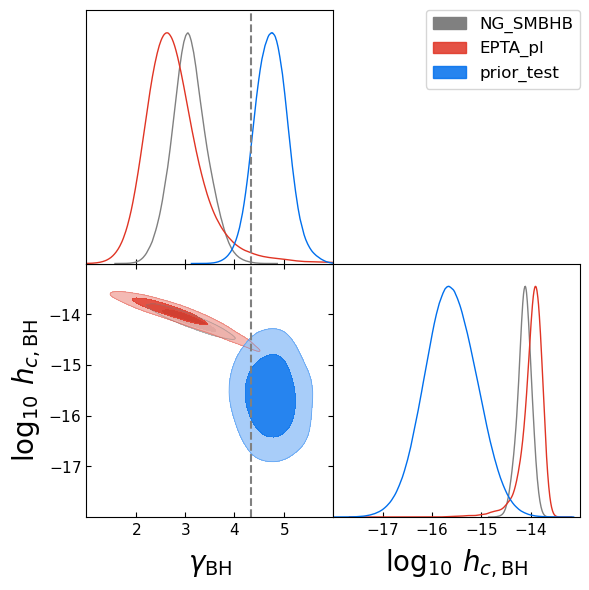

In [3]:
prior_sample = loadMCSamples(os.path.abspath('chains/prior_test'), 
                          settings={'ignore_rows':0.3},
                         )
PTA_sample = loadMCSamples(os.path.abspath('chains/NG_SMBHB'), 
                           #os.path.abspath('chains/EPTA_SMBHB'), 
                          settings={'ignore_rows':0.3},
                         )

EPTA_pl_sample = loadMCSamples(os.path.abspath('chains/EPTA_pl'),
                          #settings={'ignore_rows':0.3},
                         )

gdplot = gdplt.get_subplot_plotter(subplot_size=3)
gdplot.settings.scaling = False
gdplot.settings.axes_labelsize = 20
gdplot.triangle_plot([PTA_sample, 
                      EPTA_pl_sample,
                      prior_sample], ['gamma_BBH', 'A_BBH'], 
                     param_limits = {'gamma_BBH':[1,6], 
                                     'A_BBH':[-18,-13]},
                     filled=True)
for ax in gdplot.subplots[:,0]:
    ax.axvline(13/3, color='gray', ls='--')

print(EPTA_pl_sample.getInlineLatex('A_BBH', limit=1))
print(EPTA_pl_sample.getInlineLatex('gamma_BBH', limit=1))
print(PTA_sample.getInlineLatex('A_BBH', limit=1))
print(PTA_sample.getInlineLatex('gamma_BBH', limit=1))

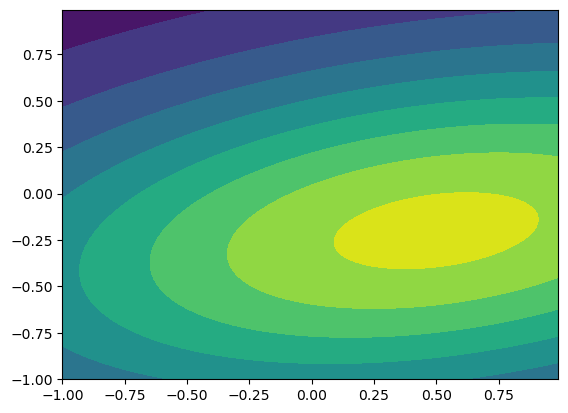

In [149]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos),
            #[0.05,0.1,], linewidths=10, ls='solid', alpha=0.1, c='k',
            )